<H1>AGENT PRACTICE TIME LESSGOOO

<h3>#1. The task is to build a pretty simple AI - just create a simple graph with one node (the llm) which takes user input and then returns an AI output

In [13]:
from typing import TypedDict, List
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
from langgraph.graph import START, END, StateGraph

class AgentState(TypedDict):
    messages: List[HumanMessage]

llm = ChatOllama(model="qwen2.5:0.5b")

def process_node(state: AgentState) -> AgentState:
    """This node simply sends the user input as a human message to chat ollama llm, and prints its response without recording it in the state"""
    response = llm.invoke(state["messages"])
    print("\nAI: " + response.content)
    return state

graph = StateGraph(AgentState)
graph.add_node("process", process_node)
graph.add_edge(START, "process")
graph.add_edge("process", END)

app = graph.compile()
# from IPython.display import Image, display
# display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
user_input = input("Enter: ")
while user_input != 'exit':
    print("\nHuman: " + user_input)
    app.invoke({"messages": [HumanMessage(content=user_input)]})
    user_input = input("Enter: ")


Human: Yoooo

AI: Hello! How can I assist you today?

Human: How you doing bb gal

AI: Hello! I'm Qwen, an AI language model designed to assist with various tasks. How may I be of help today?

Human: Me casa su casa

AI: ¡Hola! ¿Cómo puedo ayudarte hoy? No tengo una "casa" en la que vivir, pero estoy aquí para asistir con cualquier tipo de información o tarea que puedas proporcionar. ¿Podrías compartírmelo más abajo?

Human: Where do you live bb

AI: As an artificial intelligence language model, I don't physically reside or have a physical location. However, my developers and creators work remotely from my data centers located in various locations across the world to ensure that they can continue to provide high-quality services even when I'm not in action. Please feel free to ask me any questions or express your thoughts using natural language processing techniques!


<h3>#2 Time for more complications! The previous one did not have any memory, so lets start working on giving it something like that

In [22]:
from typing import TypedDict, List, Union
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage

class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]

llm = ChatOllama(model="qwen2.5:0.5b")

def process_node(state: AgentState)-> AgentState:
    """This node will invoke a response from the llm"""
    response = llm.invoke(state['messages'])
    print("\nAI: "+response.content)
    return state

conversation_history = []

graph = StateGraph(AgentState)
graph.add_node("process", process_node)
graph.add_edge(START, "process")
graph.add_edge("process", END)

app = graph.compile()
#from IPython.display import Image, display
#display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
user_input = input("Enter: ")
while user_input != 'exit' :
    print("\nHuman: " + user_input)
    conversation_history.append(HumanMessage(content=user_input))
    result = app.invoke({'messages': conversation_history})
    conversation_history = result["messages"]
    user_input = input("Enter: ")




Human: hello

AI: Hello! How can I assist you today?

Human: buddy

AI: Hello! How can I help you today?

Human: how we donig?

AI: Hello! How can I assist you today?

Human: what is my name

AI: Hello! I'm Qwen, an artificial intelligence created by Alibaba Cloud. How can I help you today? Is there anything specific you would like to know or discuss about AI technology and its applications?


<h3>#3. Time for agent type 3 - a ReAct Agent!! (Reasoning and Acting Agent)!! </h3>

<p> here, we have : START -> Agent -> END
<br><t> where the Agent <-> Tools


<p> New tools to be used:
<ul>
<li>Annotated - provides additional context to a type without affecting the type itself, kind of like a meta tag</li>
<li>Sequence - automatically handles state updates for sequences such as adding new messages to conversation history</li>
<li>BaseMessage - parent class for all message types in langchain core, like Human message, AI message, etc</li>
<li>SystemMessage - used to give direct instructions to the LLM</li>
<li>ToolMessage - passes data to the LLM after it calls a tool such as the content and the tool call ID</li>
</ul>

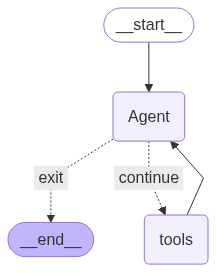

In [45]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages # a reducer function which allows merging all data into the state efficiently. If we dont use this reducer function, the updates may replace the existing value entirely!
from langgraph.prebuilt import ToolNode

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

@tool
def add(a: int, b: int):
    """This is an addition function which adds 2 numbers together"""
    return a+b

@tool
def mul(a: int, b: int):
    """This is a multiplication function which multiplies 2 numbers together"""
    return a*b

@tool
def sub(a: int, b: int):
    """This is an subtraction function which subtracts b from a"""
    return a-b

@tool
def div(a: int, b: int):
    """This is an division function which divides b from a"""
    return a/b

tools = [add, sub, mul, div]

#llm = ChatOllama(model="qwen2.5:0.5b").bind_tools(tools)
llm = ChatOllama(model="qwen3").bind_tools(tools)
def call_llm(state: AgentState) -> AgentState:
    """This function invokes the llm and gives it basic context"""
    system_prompt = SystemMessage(
        content="You are a helpful AI Assistant. Answer all questions to the best of your abilities."
    )
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

def should_continue(state: AgentState):
    """This function decides if the agent should call a tool or if it should terminate the program"""
    messages = state["messages"]
    lastMessage = messages[-1]
    if not lastMessage.tool_calls:
        return "exit"
    else:
        return "continue"
    
graph = StateGraph(AgentState)

graph.add_node("Agent", call_llm)
tool_node = ToolNode(tools=tools)
graph.add_node("tools",tool_node)

graph.add_edge(START, "Agent")

graph.add_conditional_edges(
    "Agent",
    should_continue,
    {
        "exit": END,
        "continue": "tools"
    }
)

graph.add_edge("tools", "Agent")

app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
    

In [1]:
def print_messages(messages):
    """Function made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\nTOOL RESULT: {message.content}")

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke.")]}
print_stream(app.stream(inputs, stream_mode="values"))

NameError: name 'app' is not defined

<h3> AND NOWWW, JUMPING STRAIGHT INTO THE RAG AGENT LETS END THIS TUTORIAL BBBB